In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [2]:
dataset = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
dataset.drop('id', axis=1, inplace=True)
dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
for train_indeces, test_indeces in split.split(dataset, y=dataset['stroke']):
    train = dataset.loc[train_indeces]
    test = dataset.loc[test_indeces]

In [4]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [5]:
from ydata_profiling import ProfileReport
report = ProfileReport(train, explorative=True)

<AxesSubplot: >

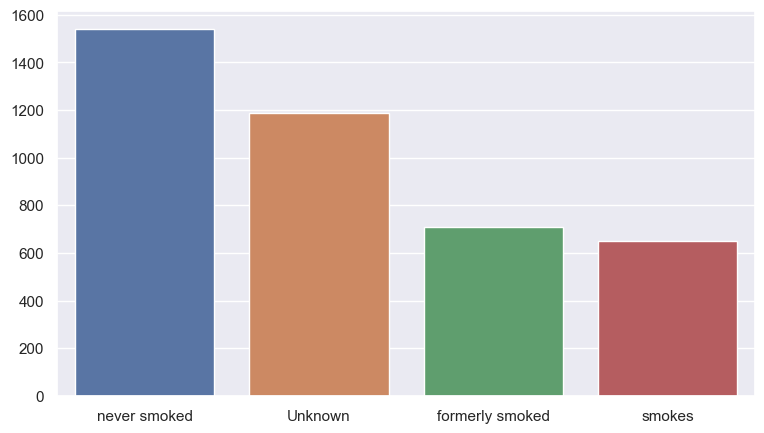

In [6]:
series = train['smoking_status'].value_counts()
sns.set(rc={'figure.figsize':(9,5)})
sns.barplot(x=series.index, y=series.values)

In [7]:
had_stroke = train.stroke == 1

<AxesSubplot: >

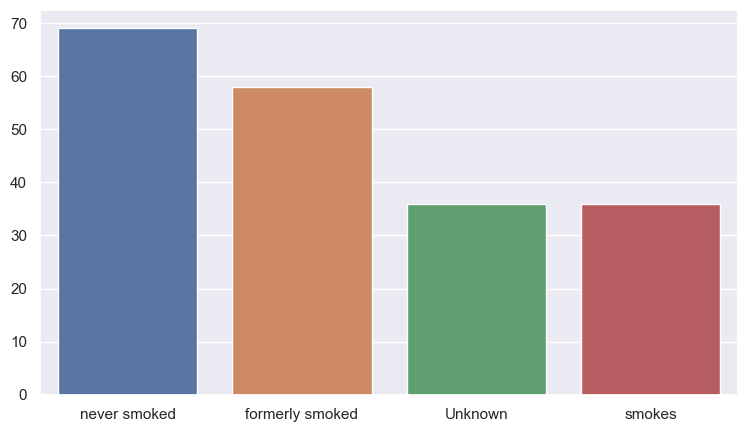

In [8]:
series = train.loc[had_stroke, 'smoking_status'].value_counts()
sns.set(rc={'figure.figsize':(9,5)})
sns.barplot(x=series.index, y=series.values)

In [9]:
smoked_ = train.loc[had_stroke, 'smoking_status'].value_counts()
smoked_ = smoked_.loc[['formerly smoked', 'smokes']].sum() / smoked_.sum()
'Formerly smoked or smokes: ' + str(smoked_)

'Formerly smoked or smokes: 0.4723618090452261'

In [10]:
high_blood_sugar = train.loc[had_stroke & (train.avg_glucose_level > 100)].shape[0]/train.loc[(train.stroke == 1)].shape[0]
'blood sugar level is higher than normal: ' + str(high_blood_sugar)

'blood sugar level is higher than normal: 0.5477386934673367'

In [11]:
high_bmi = train.loc[had_stroke & (train.bmi > 25)].shape[0]/had_stroke.sum()
'bmi metric is higher than normal: ' + str(high_bmi)

'bmi metric is higher than normal: 0.7085427135678392'

In [12]:
work_distribution = train.work_type.value_counts() / train.shape[0]
work_had_stroke_distribution = train.loc[train.stroke==1].work_type.value_counts() / train.loc[train.stroke==1].shape[0]
df = pd.concat([work_distribution, work_had_stroke_distribution], axis=1).fillna(0)
df.columns = ['overall', 'stroke']
df

,overall,stroke
Private,0.573386,0.608040
Self-employed,0.163405,0.251256
Govt_job,0.132828,0.135678
children,0.126712,0.005025
Never_worked,0.003669,0.000000


Conclusions:
The older a person gets, the higher are their chances of having a stroke. At least 47% of people, who had a stroke, smoked during some period of their lives. High blood sugar levels are also indicative of a possible stroke, as well as excessive weight. People, who selected "children" and 'never worked' as their work type, are most likely to not have a stroke (1/533). On the other hand, self-employed people are more prone to have a stroke than others.

In [13]:
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(sparse_output=False)
cat = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
train_cat = one_hot.fit_transform(train[cat])

In [14]:
train_cat = pd.DataFrame(train_cat, columns = one_hot.get_feature_names_out())
train = pd.concat([train.drop(cat, axis=1), train_cat], axis=1)

In [15]:
train.drop(train.loc[train['gender_Other'] == 1].index, axis=0, inplace=True)
train.drop(['gender_Female', 'gender_Other', 'Residence_type_Rural', 'ever_married_No'], axis=1, inplace=True)

In [16]:
from ydata_profiling import ProfileReport
had_stroke = train.loc[train.stroke == 1]
report = ProfileReport(had_stroke, explorative=True)

In [17]:
bmi_median = train['bmi'].median()
train['bmi'].fillna(bmi_median, inplace=True)

In [18]:
train.head(n=3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,29.0,0,0,57.02,43.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,47.0,0,0,74.80,23.5,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,49.0,1,0,107.91,25.0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [20]:
from sklearn.tree import export_graphviz
from IPython.display import Image

In [21]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [22]:
def validate(tree, params, train=train):
    X_train, y_train = train.drop('stroke', axis=1), train.stroke
    grid = GridSearchCV(tree, params, cv=5, scoring='roc_auc', verbose=0)
    grid.fit(X_train, y_train)
    cv_score = grid.best_score_
    tree = grid.best_estimator_
    tree.fit(X_train, y_train)
    train_pred = tree.predict(X_train)
    print('train: ', roc_auc_score(y_train, train_pred), ', validation: ', cv_score)

    export_graphviz(
        tree,
        feature_names = X_train.columns,
        out_file='tree.dot',
        filled=True
    )

    !dot -Tpng tree.dot -o tree.png
    
    print(pd.DataFrame(confusion_matrix(y_train, train_pred, labels=[0,1]), index=['True_N', 'True_Y'], columns=['Pred_N', 'Pred_Y']), '\n')
    
    print(grid.best_estimator_, '\n')
    
    importances = list(zip(X_train.columns, tree.feature_importances_))
    importances.sort(key = lambda x: x[1], reverse=True)
    for feature in importances:
        print(feature)
    return grid.best_estimator_, Image("tree.png", width=550, height=400)

I chose ROC AUC as a metric because in this problem our main goal is to detect as many people, who might have a stroke, as possible, without filling up the hospitals and worrying the ones that are healthy.

In [23]:
tree = DecisionTreeClassifier(criterion='entropy',
                                 max_depth=None,
                                 min_samples_leaf=1,
                                 random_state=20)
validate(tree, {})

train:  1.0 , validation:  0.5514019769225424
        Pred_N  Pred_Y
True_N    3888       0
True_Y       0     199 

DecisionTreeClassifier(criterion='entropy', random_state=20) 

('avg_glucose_level', 0.3113972284924113)
('age', 0.28505293845111623)
('bmi', 0.23369009528124754)
('gender_Male', 0.02773441274048946)
('smoking_status_formerly smoked', 0.019380845709521703)
('ever_married_Yes', 0.019121892258955366)
('smoking_status_Unknown', 0.017219575763515953)
('Residence_type_Urban', 0.01513976422578035)
('smoking_status_smokes', 0.014104224948153986)
('hypertension', 0.012207449133280509)
('smoking_status_never smoked', 0.011975615057363942)
('work_type_Self-employed', 0.011609074821864742)
('work_type_Private', 0.010888879488021013)
('heart_disease', 0.010478003628277971)
('work_type_Govt_job', 0.0)
('work_type_Never_worked', 0.0)
('work_type_children', 0.0)


(DecisionTreeClassifier(criterion='entropy', random_state=20),
 <IPython.core.display.Image object>)

In [24]:
params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_leaf': [1, 5, 10, 15, 20, 30],
          'max_leaf_nodes': [None, 10, 20, 50, 100]}

train:  0.7721897812105796 , validation:  0.8170789165037237
        Pred_N  Pred_Y
True_N    2351    1537
True_Y      12     187 

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=15, random_state=20) 

('age', 0.8733028777238867)
('bmi', 0.08063437548070655)
('smoking_status_never smoked', 0.03324177984040274)
('avg_glucose_level', 0.012820966955004048)
('hypertension', 0.0)
('heart_disease', 0.0)
('gender_Male', 0.0)
('ever_married_Yes', 0.0)
('work_type_Govt_job', 0.0)
('work_type_Never_worked', 0.0)
('work_type_Private', 0.0)
('work_type_Self-employed', 0.0)
('work_type_children', 0.0)
('Residence_type_Urban', 0.0)
('smoking_status_Unknown', 0.0)
('smoking_status_formerly smoked', 0.0)
('smoking_status_smokes', 0.0)


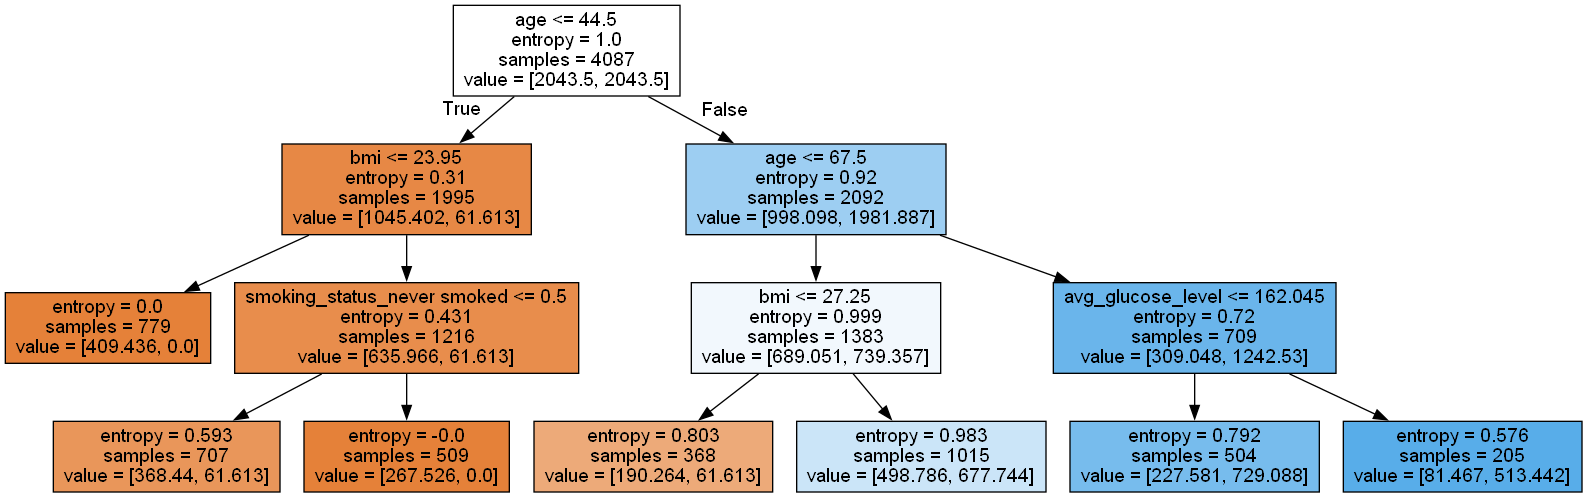

In [25]:
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=3,
                             min_samples_leaf=5,
                             random_state=20,
                             class_weight='balanced',
                             max_leaf_nodes = None,
                             min_impurity_decrease = 0.0)
tree, image = validate(tree, params)
image

The older you get, the more likely you'll have a stroke. People between 45 and 68 years old might have a stroke if they have excessive weight. If you are 68 and older, and your blood sugar is really high, you are at the big risk of having a stroke. Young people are fine, but there is a slight possibility, if their bmi is 24 or higher, and they smoke. 
The model shows that age is the decisive factor, although habits and nutrition can affect the odds, especially for middle-aged people. A job and a place of living had no influence on the results.  

In [26]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr):
    plt.rcParams["figure.figsize"] = (5,5)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.show()

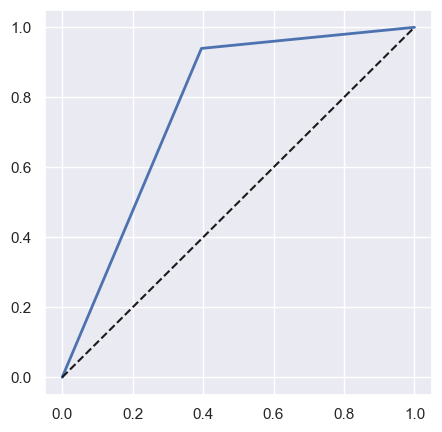

In [27]:
X_train, y_train = train.drop('stroke', axis=1), train.stroke
tree.fit(X_train, y_train)
train_pred = tree.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, train_pred)
plot_roc_curve(fpr, tpr)

In [28]:
one_hot = OneHotEncoder(sparse_output=False)
cat = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
test_cat = one_hot.fit_transform(test[cat])

In [29]:
test_cat = pd.DataFrame(test_cat, columns = one_hot.get_feature_names_out())
test = pd.concat([test.drop(cat, axis=1), test_cat], axis=1)

In [30]:
test.drop(['gender_Female', 'Residence_type_Rural', 'ever_married_No'], axis=1, inplace=True)
bmi_median = test['bmi'].median()
test['bmi'].fillna(bmi_median, inplace=True)

In [31]:
X_test, y_test = test.drop('stroke', axis=1), test.stroke

0.7489300411522632


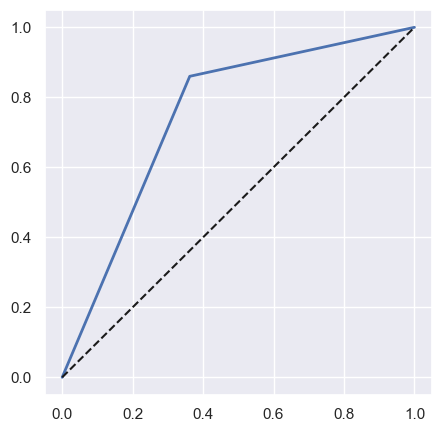

In [32]:
pred = tree.predict(X_test)
print(roc_auc_score(y_test, pred))
fpr, tpr, thresholds = roc_curve(y_test, pred)
plot_roc_curve(fpr, tpr)

I tried using Polynomial Features but that didn't improve the score either.

In [33]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train['bmi^2'] = X_train['bmi']**2
X_train['avg_glucose_level^2'] = X_train['avg_glucose_level']**2
poly_X = poly.fit_transform(X_train)
poly_train = pd.DataFrame(poly_X, columns=poly.get_feature_names_out())

In [34]:
poly_train.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)
poly_train['stroke'] = train.stroke

In [35]:
poly_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,...,smoking_status_formerly smoked smoking_status_smokes,smoking_status_formerly smoked bmi^2,smoking_status_formerly smoked avg_glucose_level^2,smoking_status_never smoked smoking_status_smokes,smoking_status_never smoked bmi^2,smoking_status_never smoked avg_glucose_level^2,smoking_status_smokes bmi^2,smoking_status_smokes avg_glucose_level^2,bmi^2 avg_glucose_level^2,stroke
0,29.00,0.0,0.0,57.02,43.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1849.00,3251.2804,0.0,0.00,0.0000,0.0,0.0,6.011617e+06,0
1,47.00,0.0,0.0,74.80,23.5,1.0,1.0,1.0,0.0,0.0,...,0.0,0.00,0.0000,0.0,552.25,5595.0400,0.0,0.0,3.089861e+06,0
2,49.00,1.0,0.0,107.91,25.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.00,0.0000,0.0,0.00,0.0000,0.0,0.0,7.277855e+06,0
3,77.00,0.0,0.0,83.06,27.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.00,0.0000,0.0,0.00,0.0000,0.0,0.0,5.029344e+06,0
4,1.72,0.0,0.0,75.79,17.6,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0000,0.0,0.00,0.0000,0.0,0.0,1.779300e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,21.00,0.0,0.0,98.01,24.2,1.0,1.0,0.0,0.0,1.0,...,0.0,0.00,0.0000,0.0,0.00,0.0000,0.0,0.0,5.625634e+06,0
4083,51.00,0.0,0.0,239.28,35.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.00,0.0000,0.0,1225.00,57254.9184,0.0,0.0,7.013728e+07,0
4084,38.00,0.0,0.0,61.27,44.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.00,0.0000,0.0,0.00,0.0000,0.0,0.0,7.267769e+06,0
4085,26.00,0.0,0.0,200.28,31.9,1.0,0.0,0.0,0.0,0.0,...,0.0,1017.61,40112.0784,0.0,0.00,0.0000,0.0,0.0,4.081845e+07,0


In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

In [37]:
params_lasso = {'alpha' : [30, 34, 36]}
lasso_reg = Lasso()
grid = GridSearchCV(lasso_reg, params_lasso, cv=5, scoring='roc_auc', verbose=0)
grid.fit(poly_train.drop('stroke', axis=1), poly_train.stroke)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [30, 34, 36]},
             scoring='roc_auc')

In [38]:
grid.best_estimator_, grid.best_score_

(Lasso(alpha=34), 0.8272647696283502)

In [39]:
lasso_reg.set_params(**grid.best_params_)

Lasso(alpha=34)

In [40]:
tree = DecisionTreeClassifier(criterion='entropy',
                             max_depth=5,
                             min_samples_leaf=10,
                             random_state=20,
                             class_weight='balanced',
                             max_leaf_nodes = None,
                             min_impurity_decrease = 0.0)

selector = SelectFromModel(lasso_reg, threshold=None)
model = Pipeline(steps=[
    ('selector', selector),
    ('tree', tree)
])

params = {'selector__threshold': ['mean', 'median', '1.25*mean', 0.00001, 0.0000001, 0.001],
         'tree__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
          'tree__min_samples_leaf': [1, 5, 10, 15, 20, 30],
          'tree__max_leaf_nodes': [None, 10, 20, 50, 100]}
grid = GridSearchCV(model, params, scoring='roc_auc', verbose=0)
grid.fit(poly_train.drop('stroke', axis=1), poly_train.stroke)

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserW

C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
C:\Users\ASUS\machine_learning_projector\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2400 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "

GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectFromModel(estimator=Lasso(alpha=34))),
                                       ('tree',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               max_depth=5,
                                                               min_samples_leaf=10,
                                                               random_state=20))]),
             param_grid={'selector__threshold': ['mean', 'median', '1.25*mean',
                                                 1e-05, 1e-07, 0.001],
                         'tree__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'tree__max_leaf_nodes': [None, 10, 20, 50, 100],
                         'tree__min_samples_leaf': [1, 5, 10, 15, 20, 30]},
             scoring='roc_auc')

In [41]:
grid.best_params_, grid.best_score_

({'selector__threshold': 'median',
  'tree__max_depth': 4,
  'tree__max_leaf_nodes': None,
  'tree__min_samples_leaf': 20},
 0.8078074038967354)

In [43]:
df = pd.DataFrame(grid.cv_results_)
too_strict = df.loc[df['mean_test_score'].isna()].index
df.drop(too_strict, axis=0, inplace=True)
df.sort_values('mean_test_score', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
df[['params', 'mean_test_score']]

,params,mean_test_score
0,"{'selector__threshold': 'median', 'tree__max_d...",0.807807
1,"{'selector__threshold': 'median', 'tree__max_d...",0.807324
2,"{'selector__threshold': 'median', 'tree__max_d...",0.807324
3,"{'selector__threshold': 'median', 'tree__max_d...",0.807324
4,"{'selector__threshold': 'median', 'tree__max_d...",0.807221
...,...,...
955,"{'selector__threshold': 1e-07, 'tree__max_dept...",0.643750
956,"{'selector__threshold': 1e-07, 'tree__max_dept...",0.643287
957,"{'selector__threshold': '1.25*mean', 'tree__ma...",0.641898
958,"{'selector__threshold': '1.25*mean', 'tree__ma...",0.641382


In [44]:
model = grid.best_estimator_
len(model[0].get_feature_names_out()), model[0].threshold_

(190, 0.0)